In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.advec_diff_case.advec_diff_eqn_modcall as adeq

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

tf.keras.backend.set_floatx('float32')

## Define some useful classes

In [4]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, x, t):
        self.t = t
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
            
    def plot(self, u, title='Hello', t_max = None):
        fig = plt.figure(figsize=(7, 4.5), facecolor='white')
        ax_u_lowres = fig.add_subplot(111)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title(title, fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, u, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        if t_max == None:
            ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        else:
            ax_u_lowres.set_ylim(self.t[0], t_max)
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)
        
        plt.show

### Initial conditions

In [5]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

## Main part starts here

### User-defined parameters and create objects

In [6]:
app = adeq.ad_eqn_args(T = 4.0, nt = 400, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

### Solve and plot

In [7]:
u = ddeinttf(adeq.ad_eqn(op, app), u0, t)

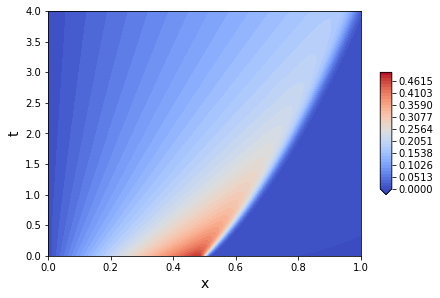

In [8]:
cp = custom_plot(x, t)

cp.plot(tf.squeeze(u, axis=1).numpy(), '')

In [9]:
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import random 

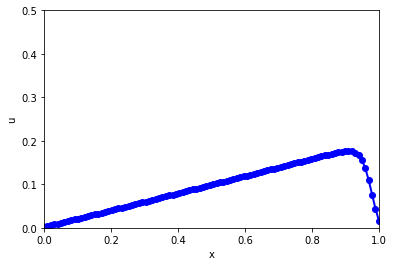

In [10]:
fig, ax = plt.subplots()
line, = plt.plot([], [], 'o-', lw=2)
labels = ['High-Res']

plotlays, plotcols = [3], ["blue"]
lines = []
for index in range(1):
    lobj = ax.plot([],[], 'o-', lw=2,color=plotcols[index])[0]
    lines.append(lobj)

def init():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    xdata = [x.numpy()]
    ydata = [tf.squeeze(u, axis=1).numpy()[frame, :]]
    
    for lnum,line in enumerate(lines):
        line.set_data(xdata[lnum], ydata[lnum]) # set data for each line separately.
#         line.set_label(labels[lnum])
#         ax.legend(loc="upper right")

        fig.gca().autoscale_view()
        fig.gca().relim()
    return lines 

ani = FuncAnimation(fig, update, frames=np.arange(len(t.numpy())),
                    init_func=init, blit=True, interval=60)

ani.save('filename_fom.gif', writer=PillowWriter(fps=24))